In [1]:
import numpy
import scipy
import sklearn
import warnings
import statsmodels
import matplotlib

In [2]:
import numpy as np
import pandas as pd
import math as m
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import statsmodels.api as sm
from statsmodels.tsa.stattools import acf
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
import scipy
from scipy import stats
from scipy.spatial import distance_matrix
from scipy.signal import find_peaks,hilbert

from tqdm import tqdm
import warnings


from visuals import *
from my_lib import *
from my_lib import NWregression

In [3]:
warnings.simplefilter('ignore')

plt.rcParams['figure.figsize'] = 5, 5
plt.rcParams['font.family'] = 'DejaVu Serif'
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 8
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['legend.fontsize'] = 16
plt.rcParams['axes.titlesize'] = 24
plt.rcParams['axes.labelsize'] = 8

In [4]:
plt.rcParams['text.usetex'] = False

In [5]:
def HankelMatrix(qwe, L):  
    N = qwe.shape[0]
    return scipy.linalg.hankel(qwe[ : N - L + 1], qwe[N - L : N])

def prepare_time_series(_dir, centred = True):
    data = pd.read_csv(_dir, delimiter =';', decimal=',')
    
    frequency = len(data)/(data['time'].values[-1]-data['time'].values[0])
    
    assert 490 < frequency < 510, f'Bad frequency {frequency}'

    _x = ((data['X_value'].values)**2 + (data['Y_value'].values)**2 + (data['Z_value'].values)**2)**.5
    
    if centred:
        _m = np.mean(_x)
        _x = (_x-_m)
        
    _t = (data['time'].values).astype(float).reshape([-1,])

    _t = np.linspace(0,_t[-1]-_t[0],len(_x))
        
    return _x,_t

In [6]:
def ro_cos(x):
    return (1 - np.cos(x))/2

def ro_chord(x,y):
    x = np.array([np.sin(x), np.cos(x)])
    y = np.array([np.sin(y), np.cos(y)])
    return np.linalg.norm(x-y)

def L1(previous_phi, phi):
    loss1 = np.zeros_like(phi)
    
    for i in range(len(phi)):
        loss1[i] = ro_cos(max(0,previous_phi - phi[i]))

    return loss1

def L2(near_phis, phi):
    loss2 = np.zeros_like(phi)
    
    for i in range(len(phi)):
        for near_phi in near_phis:
            loss2[i] += (1 - np.cos(near_phi - phi[i]))/2

    return loss2

def L3(x, x_neigh, normalization):
    x_array = np.full_like(x_neigh, x)
    loss3 = np.linalg.norm(x_array - x_neigh, axis = 1)/normalization.reshape(-1,)
    
    return loss3
    
dist = lambda x,y: np.sum((x-y)**2)**.5

def DelayEmbeddingPhaseIdentifier(
    x,
    nlags,
    epsilon = None,
    min_dim = 4,
    l1 = 1.0,
    l2 = 1.0,
    l3 = 1.0,
    n_upd = np.inf,
    make_plots = False,
    return_variance_model = False,
    return_expectation_model = False
):

    """
    TODO: DESCRIPTION
    """
    warnings.warn("The method is not optimized. Time complexity O(n^3)")

    # Autocorr and finding indeces of first period
    acf_result = acf(x[nlags-1:],
                     nlags = len(x),
                     fft = True)
    if make_plots:
        plt.figure(figsize=(15,5))
        plt.plot(acf_result)

    peaks_indices = find_peaks(acf_result)[0]
    peaks_height = acf_result[peaks_indices]
    i_indices = sorted(range(len(peaks_indices)), key=lambda i: peaks_height[i], reverse = True)[0]

    period_start, period_stop = 0, peaks_indices[i_indices]
    period = period_stop - period_start
    
    # PCA from initial phase space to lower dimention
    X_maxdim = HankelMatrix(x, nlags)
    pca = PCA(n_components = min_dim)
    X = pca.fit_transform(X_maxdim)

    # Making a model in phase space
    metric = lambda x,y: (1 - np.cos((x-y))) / 2
    phase = np.linspace(0, 2 * np.pi, period).reshape((period, 1))
    delta_phase = 0.5 * float(phase[1] - phase[0])

    expectation = NWregression(h = delta_phase,
                               metric = metric)
    expectation.fit(phase,X[period_start : period_stop])
    expectation_array = expectation.predict(phase)

    variance_init = 0.25 * max(distance_matrix(expectation_array, expectation_array, p = 2).reshape(-1,))
    variance = NWregression(h = delta_phase,
                            metric = metric)
    variance.fit(phase,np.full((len(expectation_array),1), variance_init))
    variance_array = variance.predict(phase)

    # Area for history point
    if epsilon is None:
        epsilon = 0.5 * variance_init

    # Implementing of phase retrieval algo 
    history_phase = []
    history_x = []
    n_points = len(expectation_array)
    model_phases = np.linspace(0, 2 * np.pi, n_points)
    
    # Updating models parametres
    prev_update = 0
    
    for i in (np.arange(len(X))):
        # Nearest neigh at the beggining of alg
        if len(history_phase) == 0:
            model_indeces = np.argmin(distance_matrix(np.array([X[i]]), expectation_array, p = 2))
            current_phi = model_phases[model_indeces]
            history_x.append(X[0])
            history_phase.append(float(current_phi))
            continue

        # Nearest neigh at the approximation function
        model_indeces = np.array([j for j in range(n_points)
                                  if np.linalg.norm(X[i] - expectation_array[j]) <= variance_array[j]]) 


        # IF DIST IS TO BIG FOR CURRENT VARIANCE MODEL
        if len(model_indeces) == 0:
            model_indeces = np.argmin(distance_matrix(np.array([X[i]]), expectation_array, p = 2))
            possible_phi = np.array([model_phases[model_indeces]])
            VARIANCE = np.array([variance_array[model_indeces]])
            EXPECT = np.array([expectation_array[model_indeces]])
        else:
            possible_phi = model_phases[model_indeces]
            VARIANCE = variance_array[model_indeces]
            EXPECT = expectation_array[model_indeces]

        # Nearest neigh at the history
        near_from_history = np.array([history_phase[j] for j in range(len(history_x))
                                      if np.linalg.norm(X[i] - history_x[j]) <= epsilon])

        # Choosing phi acording to loss function
        idx_min = np.argmin(l1 * L1(history_phase[-1], possible_phi)\
                            + l2 * L2(near_from_history, possible_phi)\
                            + l3 * L3(X[i], EXPECT, VARIANCE)
                           )

        current_phi = possible_phi[idx_min]

        # Filling in history
        history_x.append(X[i])
        history_phase.append(float(current_phi))
        
        # Updates models
        if np.abs(history_phase[-1] -  2 * np.pi) < 0.02 and np.abs(i - prev_update) > (1/4 + n_upd)*period:
            
            prev_update = i.copy()
            
            expectation = NWregression(h = delta_phase,
                                       metric = metric)
            expectation.fit(np.array(history_phase).reshape((len(history_x), 1)),
                            np.array(history_x))
            expectation_array = expectation.predict(phase)

            variance_current = np.linalg.norm(np.array(history_x) - expectation\
                                              .predict(np.array(history_phase).reshape((len(history_x), 1))),
                                              axis = 1).reshape((len(history_x), 1))
            variance = NWregression(h = delta_phase,
                                    metric = metric)
            variance.fit(np.array(history_phase).reshape((-1, 1)),
                         variance_current)
            variance_array = 3 * variance.predict(phase)

    # Preparing results
    result_dict = {}
    result_dict['phase'] = np.array(history_phase)

    if     return_variance_model:
        result_dict['variance'] = variance_array

    if return_expectation_model:
        result_dict['expectation'] = expectation_array
    return result_dict

In [7]:
dir_list = ['dws_11','ups_12', 'wlk_7', 'wlk_15', 'wlk_8',
            'dws_2', 'jog_9', 'ups_3', 'ups_4', 'jog_16',
            'dws_1']
dir_list = sorted(dir_list, reverse=True)

In [8]:
dir_list

['wlk_8',
 'wlk_7',
 'wlk_15',
 'ups_4',
 'ups_3',
 'ups_12',
 'jog_9',
 'jog_16',
 'dws_2',
 'dws_11',
 'dws_1']

In [9]:
from scipy.fft import fft

In [10]:
df = pd.read_csv(f'./data/A_DeviceMotion_data/wlk_8/sub_1.csv')
x_acc = np.sum(df[['userAcceleration.x', 'userAcceleration.y','userAcceleration.z']].to_numpy()**2,axis = 1)**.5
x_acc = x_acc[:1000]

In [11]:
# Fs = 50
# N = len(x_acc)
# __A = 2.0/N * np.abs(fft(x_acc)[0:N//2])
# __FS = np.linspace(0.0, 1.0/2.0*Fs, N//2)

In [12]:
# fig = go.Figure()
# fig.add_scatter(x = __FS, y = __A,
#                 mode='lines')
# fig['layout']['yaxis1'].update(title='FFT')
# fig['layout']['xaxis1'].update(title='Frec[1/s]')
# fig.show()

In [13]:
# peaks_indices = find_peaks(__A)[0]
# peaks_height = __A[peaks_indices]
# i_max = sorted(range(len(peaks_indices)), key = lambda i: peaks_height[i], reverse = True)[:2]
# i_max = peaks_indices[i_max]

In [14]:
# x_inverse_fft = np.zeros(len(x_acc))
# t = np.arange(len(x_inverse_fft))/50
# for i in i_max:
#     x_inverse_fft += __A[i]*np.cos(2*np.pi*__FS[i]*t)

In [15]:
from scipy.signal import hilbert



In [16]:
X_maxdim = HankelMatrix(x_acc, 100)
pca = PCA(n_components = 1)
X = pca.inverse_transform(pca.fit_transform(X_maxdim))

In [17]:
def diag_mean(X):
    l = X.shape[0]+X.shape[1]-1
    X_full = np.zeros((X.shape[0],l))
    for i, row in enumerate(X):
        X_full[i,i:(i+X.shape[1])] = row
    x = X_full.mean(axis=0)/(X_full != 0).sum(axis=0)
    return x

In [18]:
t_mod = np.linspace(0,30,500)
#nu = (1 + 0.05 * np.sin( 2 * np.pi * 1/20 * t_mod))
nu = np.linspace(1, 1.5, 500)
x_mod = nu * np.sin(2 * np.pi/5 * t_mod)

expected = (2 * np.pi/5 * nu * t_mod)%(2*np.pi)



In [19]:
# # x_clear = diag_mean(X)
# t = np.linspace(0,20,300)
# x_clear = np.sin(2*np.pi * t)

# z = hilbert(x_clear)

In [20]:
plt.figure(figsize=(15,5))
plt.plot(x_clear[:50])


plt.figure(figsize=(15,5))

plt.plot(inst_phase[:50])
plt.show()

NameError: name 'x_clear' is not defined

<Figure size 1080x360 with 0 Axes>

In [ ]:
fig = go.Figure()
fig.add_scatter(x = np.arange(len(__A)), y = __A,
                mode='lines')

fig['layout']['yaxis1'].update(title='FFT')
fig['layout']['xaxis1'].update(title='Frec[1/s]')
fig.show()

In [21]:
def plot_signal_phase(x_acc, phase, freq=500, save_path=None):
    
    def _scatter_phase(y, phase, ax, ax_phase, freq=500):
        # no labels
        ax.tick_params(axis="x", labelbottom=False)
        ax.set_ylabel('$s(t)$', size=20)
        # the scatter plot:
        ax.plot(y)

        # now determine nice limits by hand:
        binwidth = 0.25
#         xymax = max(np.max(np.abs(x)), np.max(np.abs(y)))
#         lim = (int(xymax/binwidth) + 1) * binwidth

        ax_phase.plot(phase)
        ax_phase.set_yticks(np.linspace(0, 2*np.pi, 9))
        ax_phase.set_yticklabels([r"0",
                                  r"$\pi/4$",
                                  r"$\pi/2$",
                                  r"$3\pi/4$",
                                  r"$\pi$",
                                  r"$5\pi/4$",
                                  r"$3\pi/2$",
                                  r"$7\pi/4$",
                                  r"$2\pi$"])
        ax_phase.set_xticks(np.arange(len(y))[::freq])
        ax_phase.set_xticklabels(np.round(np.arange(len(y))/freq, 2)[::freq])
        ax_phase.set_xlabel('$t,c$', size=20)
        ax_phase.set_ylabel('$\phi(t)$', size=20)


    left, width = 0.1, 1.
    bottom, height = 0.1, 0.3
    spacing = 0.005


    rect_plot = [left, bottom, width, height]
    rect_histx = [left, bottom + height + spacing, width, 0.2]

    # start with a square Figure
    fig = plt.figure(figsize=(5, 8))

    ax = fig.add_axes(rect_histx)
    ax_phasex = fig.add_axes(rect_plot, sharex=ax)

    # use the previously defined function
    _scatter_phase(x_acc, phase, ax, ax_phasex, freq=freq)
    if save_path is not None:
        fig.tight_layout()
        fig.savefig(save_path,
                    format='eps',
                    dpi=600,
                    bbox_inches='tight')
    plt.show()

.wlk_8_sub_1


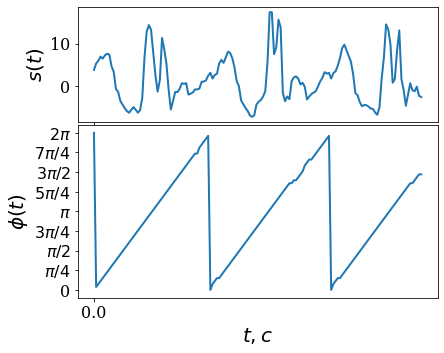

./images_paper/dataset_wlk_8_sub_1.png
.wlk_8_sub_2


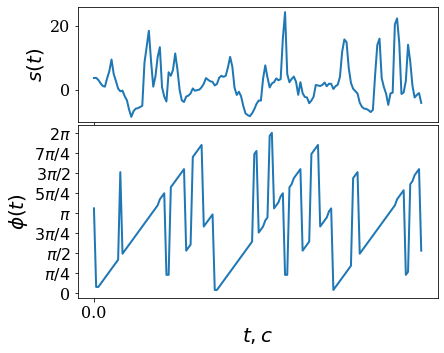

./images_paper/dataset_wlk_8_sub_2.png
.wlk_8_sub_3


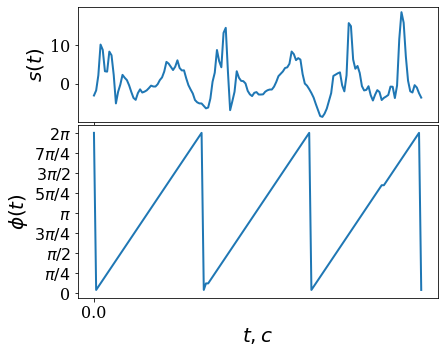

./images_paper/dataset_wlk_8_sub_3.png
.wlk_7_sub_1


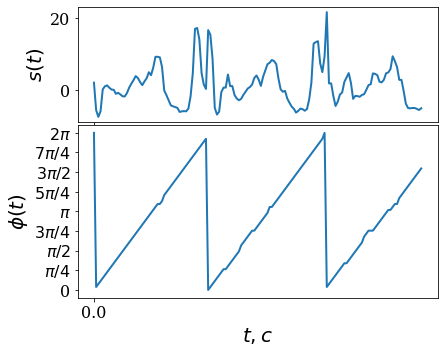

./images_paper/dataset_wlk_7_sub_1.png
.wlk_7_sub_2


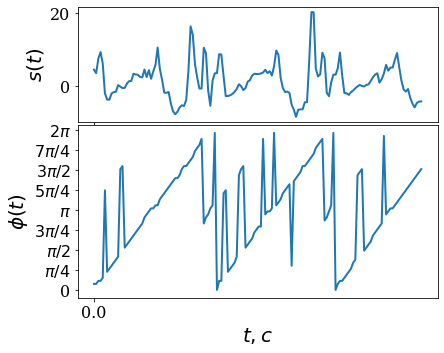

./images_paper/dataset_wlk_7_sub_2.png
.wlk_7_sub_3


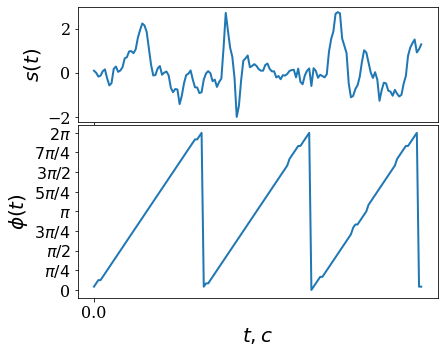

./images_paper/dataset_wlk_7_sub_3.png
.wlk_15_sub_1


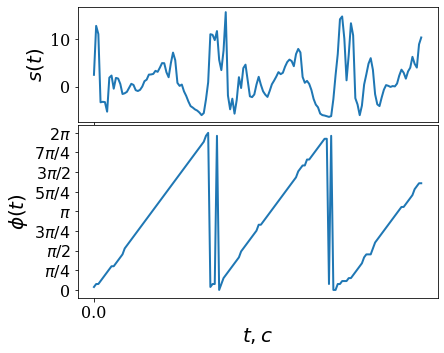

./images_paper/dataset_wlk_15_sub_1.png
.wlk_15_sub_2


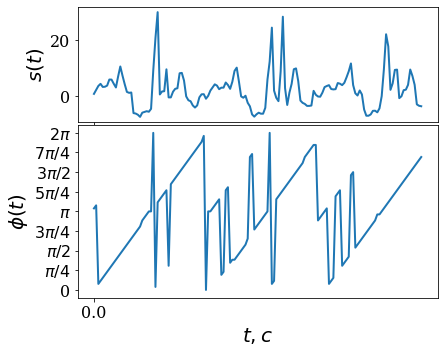

./images_paper/dataset_wlk_15_sub_2.png
.wlk_15_sub_3


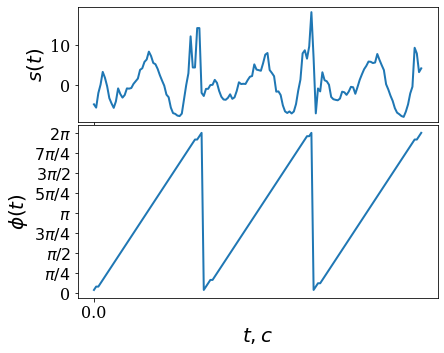

./images_paper/dataset_wlk_15_sub_3.png
.ups_4_sub_1


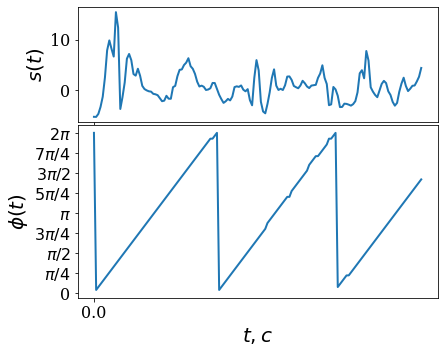

./images_paper/dataset_ups_4_sub_1.png
.ups_4_sub_2


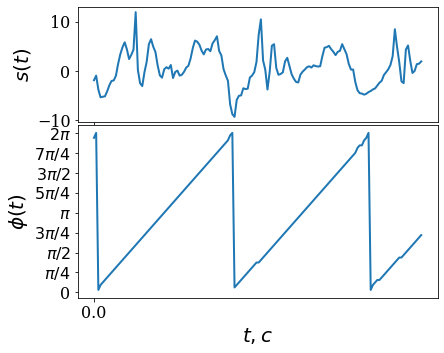

./images_paper/dataset_ups_4_sub_2.png
.ups_4_sub_3


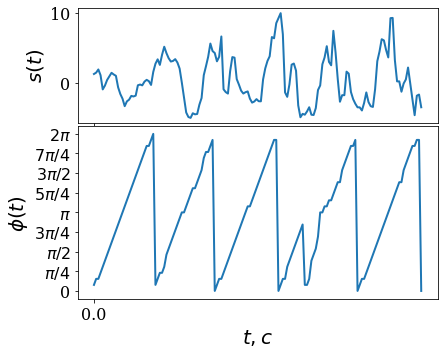

./images_paper/dataset_ups_4_sub_3.png
.ups_3_sub_1


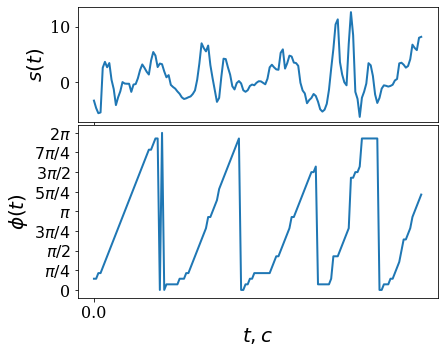

./images_paper/dataset_ups_3_sub_1.png
.ups_3_sub_2


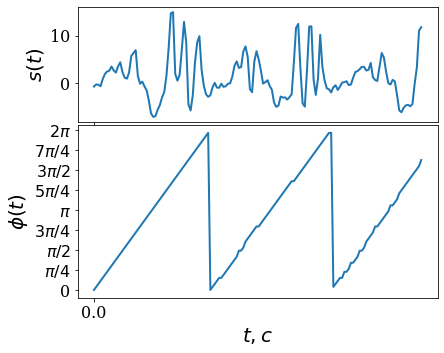

./images_paper/dataset_ups_3_sub_2.png
.ups_3_sub_3


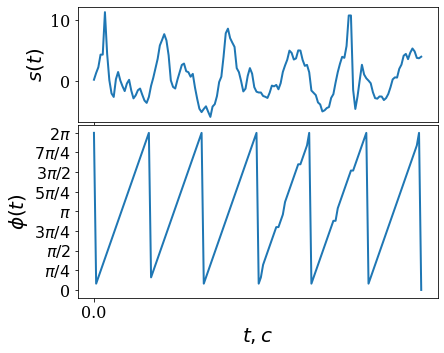

./images_paper/dataset_ups_3_sub_3.png
.ups_12_sub_1


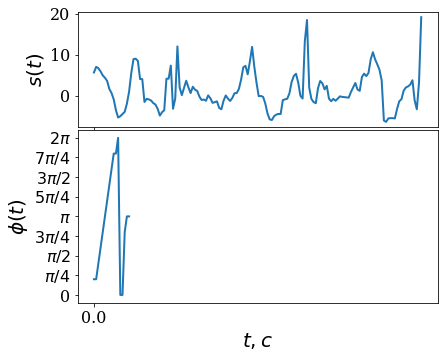

./images_paper/dataset_ups_12_sub_1.png
.ups_12_sub_2


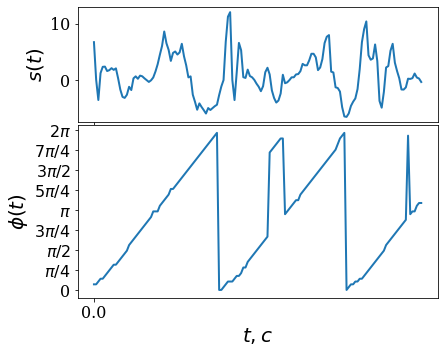

./images_paper/dataset_ups_12_sub_2.png
.ups_12_sub_3


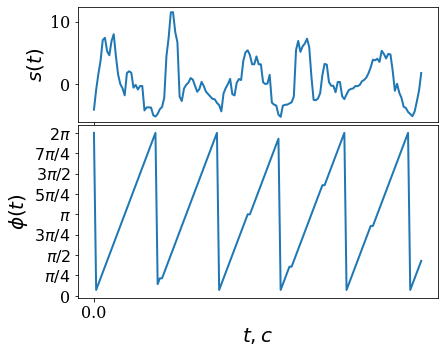

./images_paper/dataset_ups_12_sub_3.png
.jog_9_sub_1


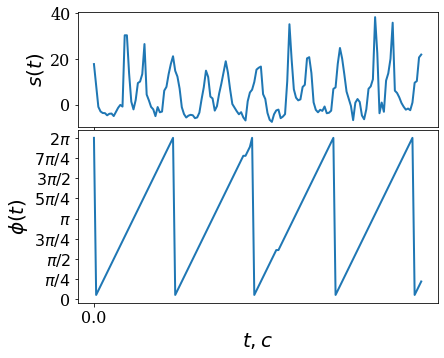

./images_paper/dataset_jog_9_sub_1.png
.jog_9_sub_2


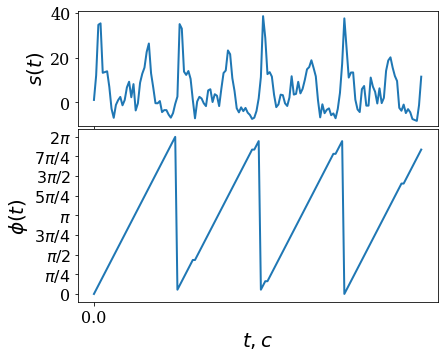

./images_paper/dataset_jog_9_sub_2.png
.jog_9_sub_3


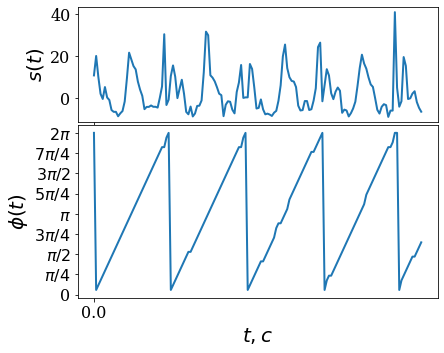

./images_paper/dataset_jog_9_sub_3.png
.jog_16_sub_1


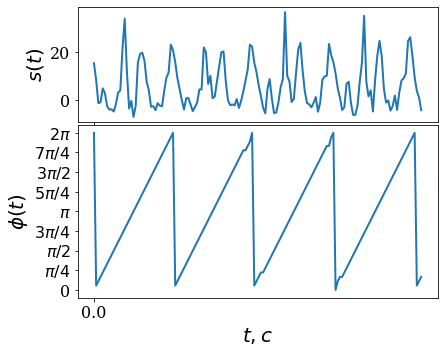

./images_paper/dataset_jog_16_sub_1.png
.jog_16_sub_2


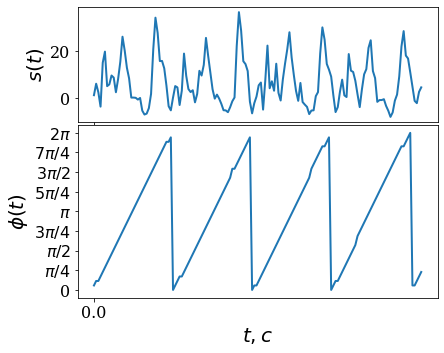

./images_paper/dataset_jog_16_sub_2.png
.jog_16_sub_3


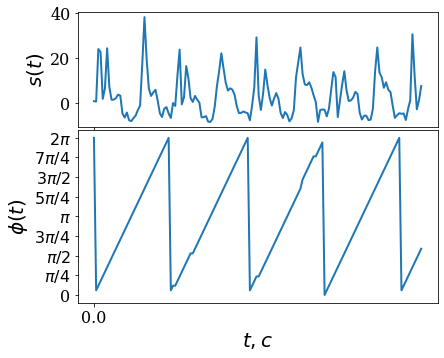

./images_paper/dataset_jog_16_sub_3.png
.dws_2_sub_1


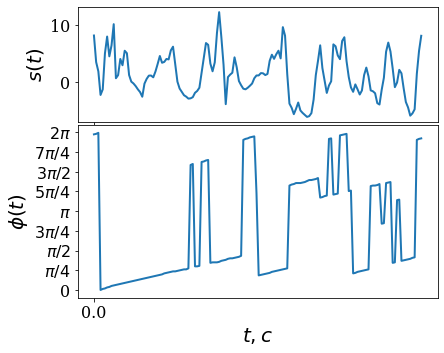

./images_paper/dataset_dws_2_sub_1.png
.dws_2_sub_2


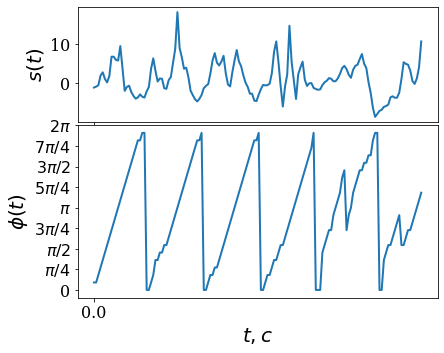

./images_paper/dataset_dws_2_sub_2.png
.dws_2_sub_3


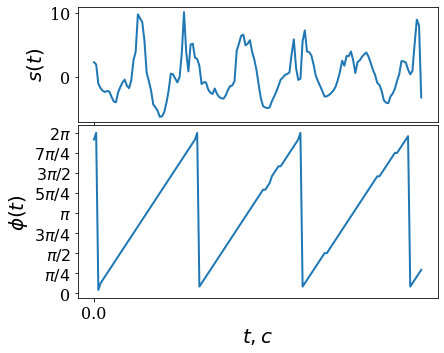

./images_paper/dataset_dws_2_sub_3.png
Automatic analysis incapable dws_11 sub_1
.dws_11_sub_2


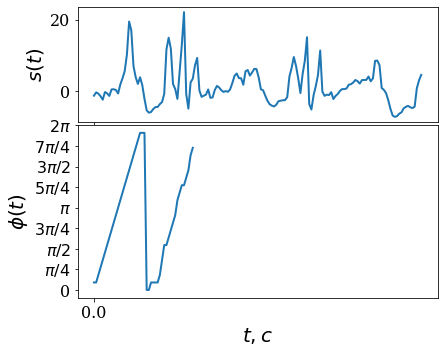

./images_paper/dataset_dws_11_sub_2.png
.dws_11_sub_3


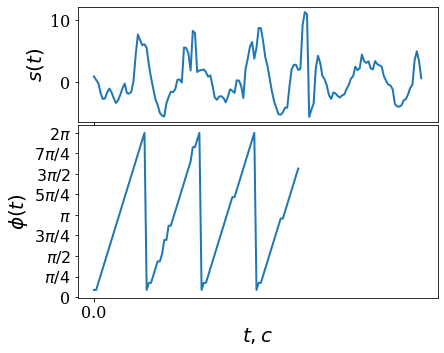

./images_paper/dataset_dws_11_sub_3.png
.dws_1_sub_1


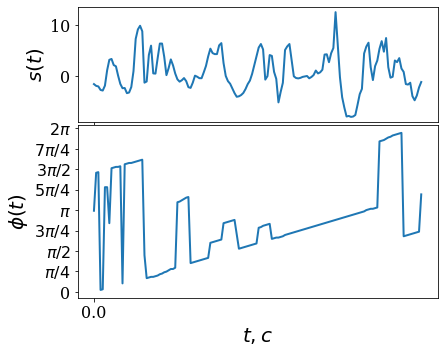

./images_paper/dataset_dws_1_sub_1.png
.dws_1_sub_2


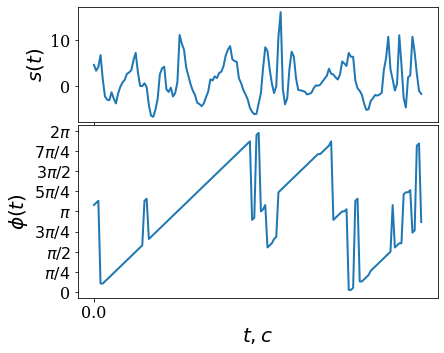

./images_paper/dataset_dws_1_sub_2.png
.dws_1_sub_3


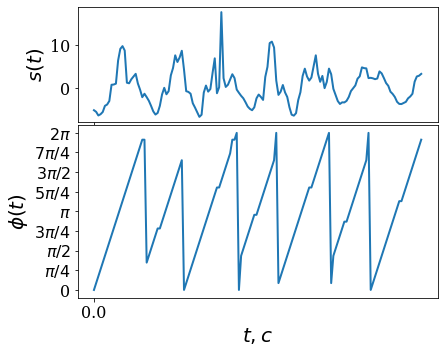

./images_paper/dataset_dws_1_sub_3.png


In [22]:
for act_type in dir_list:
    for sub in ['sub_1','sub_2','sub_3']:
        try:
            df = pd.read_csv(f'./data/A_DeviceMotion_data/{act_type}/{sub}.csv')
            x_1 = df[['gravity.x', 'gravity.y','gravity.z']].to_numpy()*9.8
            x_2 = df[['userAcceleration.x', 'userAcceleration.y','userAcceleration.z']].to_numpy()*9.8
            x_acc = x_1+x_2
            x_acc = np.sum(x_acc**2,axis = 1)**.5 - 9.8

            a = DelayEmbeddingPhaseIdentifier(x = x_acc[1000:2000],
                                              nlags = 50,
                                              l1 = 1,
                                              l2 = 1,
                                              l3 = 1,
                                              n_upd = 2,
                                              min_dim = 10)
            print(f'.{act_type}_{sub}')
            plot_signal_phase(x_acc[50:200],
                              a['phase'][:150],
#                               save_path = f'./images_paper/dataset_{act_type}_{sub}.png'
                             )
            print(f'./images_paper/dataset_{act_type}_{sub}.png')
#             fig, axs = plt.subplots(2, 1,figsize = (5,5)) 

#             axs[0].plot(x_acc[50:200])
#             axs[0].set_title(act_type+'|'+sub)
#             axs[1].plot()

#             plt.show()
        except:
            print(f'Automatic analysis incapable {act_type} {sub}')
            

___
# Метрики качества Разброс и СТД

In [23]:
def HilbertPhaseIdentifier(x):
    z = hilbert(x)
    inst_phase = np.arctan2(np.imag(z),x)%(2*np.pi)
    return inst_phase

In [24]:
def AutoCorrPhaseIdentifier(x, period, plot_acf = False):
    
    acf_result = acf(x[:], nlags = len(x), fft=True)
    
    if plot_acf:
        plt.plot(acf_result)
        
    acf_indeces_phase = scipy.signal.find_peaks(acf_result, distance = int(period * 0.75))[0]
    
    acf_indeces_phase = np.append(np.array([0]), acf_indeces_phase)
    phase = np.array([])
    for i in range(len(acf_indeces_phase)-1):
        i_start = acf_indeces_phase[i]
        i_end = acf_indeces_phase[i+1]
    
        phase = np.append(phase, np.linspace(0, 2*np.pi, int(i_end - i_start)))
    
    period_end = len(x) - acf_indeces_phase[-1]
    
    phase = np.append(phase, np.linspace(0, 2 * np.pi * period_end/period, period_end))
    return phase

In [25]:
def make_compar(x, phase_true, nlags = 50):
    
    plt.figure(figsize=(10,5))
    plt.plot(phase_true[:-100], label='True')
    
    
    phase = HilbertPhaseIdentifier(x)
    error = np.abs(phase - phase_true)[:-100]
    error = np.arccos(np.cos(error))
    
    print(f'Hilbert  STD {np.round(np.std(error),4)}  Mean {np.round(np.mean(error),4)}')
    plt.plot(phase[:-100], label='H')
    
    
    phase = AutoCorrPhaseIdentifier(x, nlags)
    error = np.abs(phase - phase_true)
    error = np.arccos(np.cos(error))[:-100]
    
    print(f'Autocorr STD {np.round(np.std(error),4)}  Mean {np.round(np.mean(error),4)}')
#     plt.plot(phase[:-100], label='A')
    
    phase = DelayEmbeddingPhaseIdentifier(x = x,
                                              nlags = nlags,
                                              l1 = 1,
                                              l2 = 1,
                                              l3 = 1,
                                              n_upd = 1,
                                              min_dim = 10)
    
    
    phase = phase['phase']
    
    error = np.abs(phase - phase_true[nlags-1:])[:-100]
    error = np.arccos(np.cos(error))
    
    print(f'Delay    STD {np.round(np.std(error),4)}  Mean {np.round(np.mean(error),4)}')
#     plt.plot(phase[:-100], label='D')
    
    
    
    
    plt.legend()
    plt.show()

In [114]:
t_mod = np.linspace(0,10,500)
nu = np.linspace(1, 1.5, 500)

x_amp = nu * np.sin(2 * np.pi * t_mod)
expected_amp = (2 * np.pi * t_mod)%(2*np.pi)

Hilbert  STD 0.0132  Mean 1.5728
Autocorr STD 0.0469  Mean 0.0716
Delay    STD 0.0401  Mean 0.1407


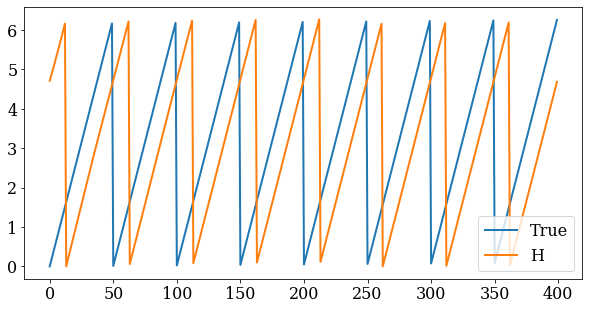

In [115]:
make_compar(x_amp, expected_amp)

In [116]:
x_frq = np.sin(2 * np.pi * nu * t_mod)
expected_frq = (2 * np.pi * nu * t_mod)%(2*np.pi)

Hilbert  STD 0.0148  Mean 1.5687
Autocorr STD 0.8487  Mean 1.4788
Delay    STD 0.4856  Mean 0.6697


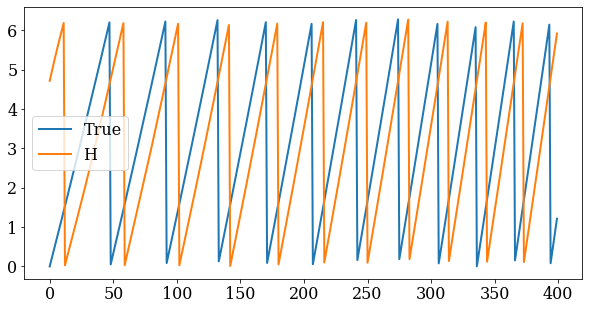

In [117]:
make_compar(x_frq, expected_frq)

In [118]:
x_compl = np.sin(2 * np.pi * t_mod) + 0.5 * np.sin(2 * np.pi * t_mod * 1/2)
expected_compl = np.arange(len(t_mod))%100/99*2*np.pi

Hilbert  STD 0.9123  Mean 1.5724
Autocorr STD 0.935  Mean 1.5756
Delay    STD 0.0317  Mean 3.0766


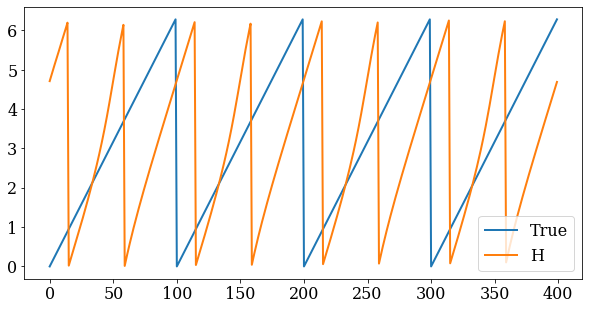

In [119]:
make_compar(x_compl, expected_compl)

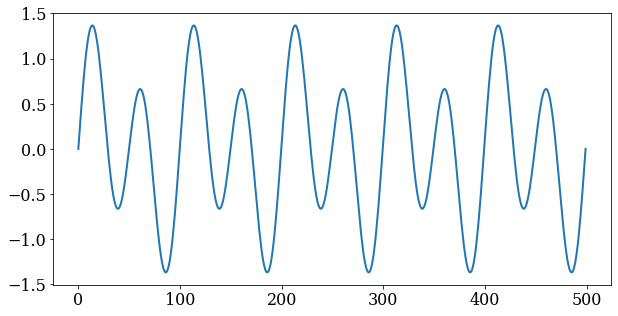

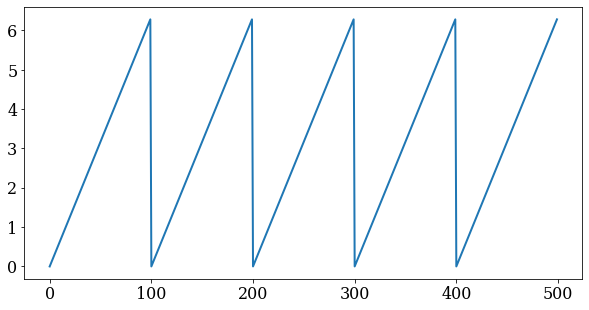

In [120]:
plt.figure(figsize=(10,5))
plt.plot(x_compl)
plt.show()
plt.figure(figsize=(10,5))
plt.plot(expected_compl)
plt.show()

In [95]:
fig = go.Figure()
fig.add_scatter(y = x_compl, mode='lines', name='Sum squares')
fig.show()